## 5. Evaluation
### Generated Image Quality Metrics

1. **FID (Fréchet Inception Distance)**
   - Measures how similar the distribution of generated images is to real images
   - Lower is better (good models: <50, excellent models: <20)
   - Uses Inception-v3 features to compare real and generated image statistics

2. **Inception Score (IS)**
   - Measures both quality and diversity of generated images
   - Higher is better (good models: >3, excellent models: >7)
   - Evaluates if images contain clear, recognizable objects and are diverse

3. **Kernel Inception Distance (KID)**
   - Similar to FID but more reliable for smaller sample sizes
   - Lower is better (good models: <0.05, excellent models: <0.02)
   - Less sensitive to sample size than FID, good for quick evaluations

4. **Diversity Score**
   - Custom metric measuring average L2 distance between pairs of generated images
   - Higher values indicate more diverse outputs
   - Helps detect mode collapse (when model generates very similar images)


In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.kid import KernelInceptionDistance
from tqdm import tqdm
import time
from torch import nn, einsum
from inspect import isfunction
from functools import partial
from src.model_unet_no_attention import Unet as Unet_No_Att
from src.model_unet import *
from src.eval_base import *

device = "cuda" if torch.cuda.is_available() else "cpu"


def evaluate_diffusion(model, test_loader, num_samples=100):
    """
    Comprehensive evaluation with all metrics
    """
    evaluator = Evaluator(model=model)
    metrics = evaluator.evaluate_samples(
        test_loader,
        #model,
        num_samples=num_samples
    )
    
    print("\n📈 Final Evaluation Results:")
    print("=" * 40)
    print(f"FID Score: {metrics['fid']:.2f}")
    print(f"Inception Score: {metrics['inception_score_mean']:.2f} ± {metrics['inception_score_std']:.2f}")
    print(f"KID Score: {metrics['kid_mean']:.4f} ± {metrics['kid_std']:.4f}")
    print(f"Diversity Score: {metrics['diversity_score']:.2f}")
    print("=" * 40)
    
    # Provide some context about the scores
    print("\n📝 Quick interpretation:")
    print("FID: Lower is better (good: <50, excellent: <20)")
    print("IS: Higher is better (good: >3, excellent: >7)")
    print("KID: Lower is better (good: <0.05, excellent: <0.02)")
    print("Diversity: Higher indicates more varied outputs")
    
    return metrics



/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def load_model(image_size, channels,path):
    if "NoAttention" in path:
        model = Unet_No_Att(
                dim=image_size,
                channels=channels,
                dim_mults=(1, 2, 4,)
            )
    elif "noattention" in path:
        model = Unet_No_Att(
                dim=image_size,
                channels=channels,
                dim_mults=(1, 2, 4,)
            )  
    else:
        model = Unet(
            dim=image_size,
            channels=channels,
            dim_mults=(1, 2, 4,)
        )
    
    checkpoint = torch.load(path)
    state_dict = checkpoint['model_state_dict']
    model.load_state_dict(state_dict)
    
    model = model.to(device)
    return model

def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

def load_flowers(batch_size):
    test_data = torch.load("../data/prepared_datasets/train_flowers.pt")
    test_labels = torch.load("../data/prepared_datasets/train_flowers_labels.pt")
    val_data = torch.load("../data/prepared_datasets/val_flowers.pt")
    val_labels = torch.load("../data/prepared_datasets/val_flowers_labels.pt")
    train_data = torch.load("../data/prepared_datasets/test_flowers.pt")
    train_labels = torch.load("../data/prepared_datasets/test_flowers_labels.pt")
    train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
    val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
    test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
    
    train_data = train_data * 2 - 1
    val_data = val_data * 2 - 1
    test_data = test_data * 2 - 1
    train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels,batch_size)
    return train_loader, val_loader, test_loader

def load_celeba(batch_size):
    test_data = torch.load("../data/prepared_datasets/test_celeba.pt")
    test_labels = torch.load("../data/prepared_datasets/train_celeba_labels.pt")
    test_data=test_data[:1000]
    test_labels = test_labels[:1000]
    test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
    test_data = test_data * 2 - 1
    test_dataset = TensorDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return test_loader

In [3]:
#model = load_model(64,3,'../models/model_flowers.pth')
#model = load_model(64,3,'../models/model_NoAttention_flowers.pth')
_, _, test_loader_flowers = load_flowers(32)
test_loader_celeba = load_celeba(32)

In [4]:
#metrics = evaluate_diffusion(
#    model,
#    test_loader,
#    num_samples=128
#)

In [5]:
metrics_df = pd.DataFrame(columns=["Model", "FID", "Inception Score Mean", "Inception Score Std", "KID Mean", "KID Std", "Diversity Score"])

# Assuming models are stored in the 'models' directory
model_dir = "../models"

# Iterate over each model in the 'models' directory
for model_filename in os.listdir(model_dir):
    if model_filename.endswith(".pth"):
        model_path = os.path.join(model_dir, model_filename)
        print("===========================================================================================")
        print(f"Evaluating {model_filename} model..." )
        print("===========================================================================================")
        # Load the model (assuming the model is a PyTorch model and can be loaded with torch.load)
        print(model_path)
        model = load_model(64,3,model_path)
        model = model.to(device)
        model.eval()
        if "flowers" in model_filename:
            test_loader = test_loader_flowers
        else:
            test_loader = test_loader_celeba
    
        # Run evaluation
        metrics = evaluate_diffusion(
            model,
            test_loader, 
            num_samples=128
        )
        
        # Append the metrics to the dataframe
        new_row = pd.DataFrame([{
            "Model": model_filename,
            "FID": metrics["fid"],
            "Inception Score Mean": metrics["inception_score_mean"],
            "Inception Score Std": metrics["inception_score_std"],
            "KID Mean": metrics["kid_mean"],
            "KID Std": metrics["kid_std"],
            "Diversity Score": metrics["diversity_score"]
        }])
        
        # Use pd.concat() to add the new row to the metrics_df
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Print or save the dataframe
#print(metrics_df)

# Optionally, save it to a CSV file
#metrics_df.to_csv("model_evaluation_results.csv", index=False)


Evaluating model_celeba.pth model...
../models/model_celeba.pth
ASD3
Initializing evaluation metrics...
cuda


/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


✓ Metrics initialized successfully

📊 Starting evaluation with 128 samples...

1️⃣ Collecting real images...
✓ Collected 128 real images

2️⃣ Generating samples...






ampling loop time step: 100%|██████████| 200/200 [00:19<00:00, 10.34it/s]

✓ Generated 128 images

3️⃣ Computing metrics...
Computing FID score...
✓ FID Score: 233.21

Computing Inception Score...
✓ Inception Score: 2.80 ± 0.39

Computing KID score...
✓ KID Score: 0.1473 ± 0.0074

Computing diversity score...
✓ Diversity Score: 14.20

✨ Evaluation completed in 81.73 seconds

📈 Final Evaluation Results:
FID Score: 233.21
Inception Score: 2.80 ± 0.39
KID Score: 0.1473 ± 0.0074
Diversity Score: 14.20

📝 Quick interpretation:
FID: Lower is better (good: <50, excellent: <20)
IS: Higher is better (good: >3, excellent: >7)
KID: Lower is better (good: <0.05, excellent: <0.02)
Diversity: Higher indicates more varied outputs
Evaluating model_celeba_max.pth model...
../models/model_celeba_max.pth
ASD3


/tmp/ipykernel_1028/1138922713.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


Initializing evaluation metrics...
cuda
✓ Metrics initialized successfully

📊 Starting evaluation with 128 samples...

1️⃣ Collecting real images...
✓ Collected 128 real images

2️⃣ Generating samples...






ampling loop time step: 100%|██████████| 200/200 [00:19<00:00, 10.23it/s]

✓ Generated 128 images

3️⃣ Computing metrics...
Computing FID score...
✓ FID Score: 219.90

Computing Inception Score...
✓ Inception Score: 2.82 ± 0.26

Computing KID score...
✓ KID Score: 0.1227 ± 0.0068

Computing diversity score...
✓ Diversity Score: 15.44

✨ Evaluation completed in 82.40 seconds

📈 Final Evaluation Results:
FID Score: 219.90
Inception Score: 2.82 ± 0.26
KID Score: 0.1227 ± 0.0068
Diversity Score: 15.44

📝 Quick interpretation:
FID: Lower is better (good: <50, excellent: <20)
IS: Higher is better (good: >3, excellent: >7)
KID: Lower is better (good: <0.05, excellent: <0.02)
Diversity: Higher indicates more varied outputs
Evaluating model_flowers.pth model...
../models/model_flowers.pth
ASD3
Initializing evaluation metrics...
cuda
✓ Metrics initialized successfully

📊 Starting evaluation with 128 samples...

1️⃣ Collecting real images...
✓ Collected 128 real images

2️⃣ Generating samples...






ampling loop time step: 100%|██████████| 200/200 [00:19<00:00, 10.27it/s]

✓ Generated 128 images

3️⃣ Computing metrics...
Computing FID score...
✓ FID Score: 278.51

Computing Inception Score...
✓ Inception Score: 1.93 ± 0.12

Computing KID score...
✓ KID Score: 0.2499 ± 0.0122

Computing diversity score...
✓ Diversity Score: 16.87

✨ Evaluation completed in 82.20 seconds

📈 Final Evaluation Results:
FID Score: 278.51
Inception Score: 1.93 ± 0.12
KID Score: 0.2499 ± 0.0122
Diversity Score: 16.87

📝 Quick interpretation:
FID: Lower is better (good: <50, excellent: <20)
IS: Higher is better (good: >3, excellent: >7)
KID: Lower is better (good: <0.05, excellent: <0.02)
Diversity: Higher indicates more varied outputs
Evaluating model_gelu_flowers.pth model...
../models/model_gelu_flowers.pth
ASD3
Initializing evaluation metrics...
cuda
✓ Metrics initialized successfully

📊 Starting evaluation with 128 samples...

1️⃣ Collecting real images...
✓ Collected 128 real images

2️⃣ Generating samples...






ampling loop time step: 100%|██████████| 200/200 [00:19<00:00, 10.19it/s]

✓ Generated 128 images

3️⃣ Computing metrics...
Computing FID score...
✓ FID Score: 430.35

Computing Inception Score...
✓ Inception Score: 1.22 ± 0.07

Computing KID score...
✓ KID Score: 0.5493 ± 0.0130

Computing diversity score...
✓ Diversity Score: 25.10

✨ Evaluation completed in 82.40 seconds

📈 Final Evaluation Results:
FID Score: 430.35
Inception Score: 1.22 ± 0.07
KID Score: 0.5493 ± 0.0130
Diversity Score: 25.10

📝 Quick interpretation:
FID: Lower is better (good: <50, excellent: <20)
IS: Higher is better (good: >3, excellent: >7)
KID: Lower is better (good: <0.05, excellent: <0.02)
Diversity: Higher indicates more varied outputs
Evaluating model_noattention_celeba.pth model...
../models/model_noattention_celeba.pth
ASD2
Initializing evaluation metrics...
cuda
✓ Metrics initialized successfully

📊 Starting evaluation with 128 samples...

1️⃣ Collecting real images...
✓ Collected 128 real images

2️⃣ Generating samples...






ampling loop time step: 100%|██████████| 200/200 [00:15<00:00, 13.12it/s]

✓ Generated 128 images

3️⃣ Computing metrics...
Computing FID score...
✓ FID Score: 237.18

Computing Inception Score...
✓ Inception Score: 2.66 ± 0.35

Computing KID score...
✓ KID Score: 0.1485 ± 0.0077

Computing diversity score...
✓ Diversity Score: 18.35

✨ Evaluation completed in 64.69 seconds

📈 Final Evaluation Results:
FID Score: 237.18
Inception Score: 2.66 ± 0.35
KID Score: 0.1485 ± 0.0077
Diversity Score: 18.35

📝 Quick interpretation:
FID: Lower is better (good: <50, excellent: <20)
IS: Higher is better (good: >3, excellent: >7)
KID: Lower is better (good: <0.05, excellent: <0.02)
Diversity: Higher indicates more varied outputs
Evaluating model_NoAttention_flowers.pth model...
../models/model_NoAttention_flowers.pth
ASD
Initializing evaluation metrics...
cuda
✓ Metrics initialized successfully

📊 Starting evaluation with 128 samples...

1️⃣ Collecting real images...
✓ Collected 128 real images

2️⃣ Generating samples...






ampling loop time step: 100%|██████████| 200/200 [00:14<00:00, 13.35it/s]

✓ Generated 128 images

3️⃣ Computing metrics...
Computing FID score...
✓ FID Score: 255.89

Computing Inception Score...
✓ Inception Score: 1.37 ± 0.11

Computing KID score...
✓ KID Score: 0.2483 ± 0.0115

Computing diversity score...
✓ Diversity Score: 22.68

✨ Evaluation completed in 64.75 seconds

📈 Final Evaluation Results:
FID Score: 255.89
Inception Score: 1.37 ± 0.11
KID Score: 0.2483 ± 0.0115
Diversity Score: 22.68

📝 Quick interpretation:
FID: Lower is better (good: <50, excellent: <20)
IS: Higher is better (good: >3, excellent: >7)
KID: Lower is better (good: <0.05, excellent: <0.02)
Diversity: Higher indicates more varied outputs
Evaluating model_postnorm_flowers.pth model...
../models/model_postnorm_flowers.pth
ASD3
Initializing evaluation metrics...
cuda
✓ Metrics initialized successfully

📊 Starting evaluation with 128 samples...

1️⃣ Collecting real images...
✓ Collected 128 real images

2️⃣ Generating samples...






ampling loop time step: 100%|██████████| 200/200 [00:19<00:00, 10.31it/s]

✓ Generated 128 images

3️⃣ Computing metrics...
Computing FID score...
✓ FID Score: 343.70

Computing Inception Score...
✓ Inception Score: 1.53 ± 0.18

Computing KID score...
✓ KID Score: 0.3552 ± 0.0111

Computing diversity score...
✓ Diversity Score: 7.54

✨ Evaluation completed in 80.94 seconds

📈 Final Evaluation Results:
FID Score: 343.70
Inception Score: 1.53 ± 0.18
KID Score: 0.3552 ± 0.0111
Diversity Score: 7.54

📝 Quick interpretation:
FID: Lower is better (good: <50, excellent: <20)
IS: Higher is better (good: >3, excellent: >7)
KID: Lower is better (good: <0.05, excellent: <0.02)
Diversity: Higher indicates more varied outputs
Evaluating model_relu_flowers.pth model...
../models/model_relu_flowers.pth
ASD3
Initializing evaluation metrics...
cuda
✓ Metrics initialized successfully

📊 Starting evaluation with 128 samples...

1️⃣ Collecting real images...
✓ Collected 128 real images

2️⃣ Generating samples...






ampling loop time step: 100%|██████████| 200/200 [00:19<00:00, 10.13it/s]

✓ Generated 128 images

3️⃣ Computing metrics...
Computing FID score...
✓ FID Score: 293.87

Computing Inception Score...
✓ Inception Score: 1.39 ± 0.11

Computing KID score...
✓ KID Score: 0.3063 ± 0.0110

Computing diversity score...
✓ Diversity Score: 21.29

✨ Evaluation completed in 82.64 seconds

📈 Final Evaluation Results:
FID Score: 293.87
Inception Score: 1.39 ± 0.11
KID Score: 0.3063 ± 0.0110
Diversity Score: 21.29

📝 Quick interpretation:
FID: Lower is better (good: <50, excellent: <20)
IS: Higher is better (good: >3, excellent: >7)
KID: Lower is better (good: <0.05, excellent: <0.02)
Diversity: Higher indicates more varied outputs
Evaluating model_silu_flowers.pth model...
../models/model_silu_flowers.pth
ASD3
Initializing evaluation metrics...
cuda
✓ Metrics initialized successfully

📊 Starting evaluation with 128 samples...

1️⃣ Collecting real images...
✓ Collected 128 real images

2️⃣ Generating samples...






ampling loop time step: 100%|██████████| 200/200 [00:19<00:00, 10.14it/s]

✓ Generated 128 images

3️⃣ Computing metrics...
Computing FID score...
✓ FID Score: 296.94

Computing Inception Score...
✓ Inception Score: 1.60 ± 0.15

Computing KID score...
✓ KID Score: 0.2927 ± 0.0179

Computing diversity score...
✓ Diversity Score: 17.26

✨ Evaluation completed in 82.53 seconds

📈 Final Evaluation Results:
FID Score: 296.94
Inception Score: 1.60 ± 0.15
KID Score: 0.2927 ± 0.0179
Diversity Score: 17.26

📝 Quick interpretation:
FID: Lower is better (good: <50, excellent: <20)
IS: Higher is better (good: >3, excellent: >7)
KID: Lower is better (good: <0.05, excellent: <0.02)
Diversity: Higher indicates more varied outputs


/tmp/ipykernel_1028/1791550989.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
/tmp/ipykernel_1028/1791550989.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
/tmp/ipykernel_1028/1791550989.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
/tmp/ipykernel_1028/1791550989.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')


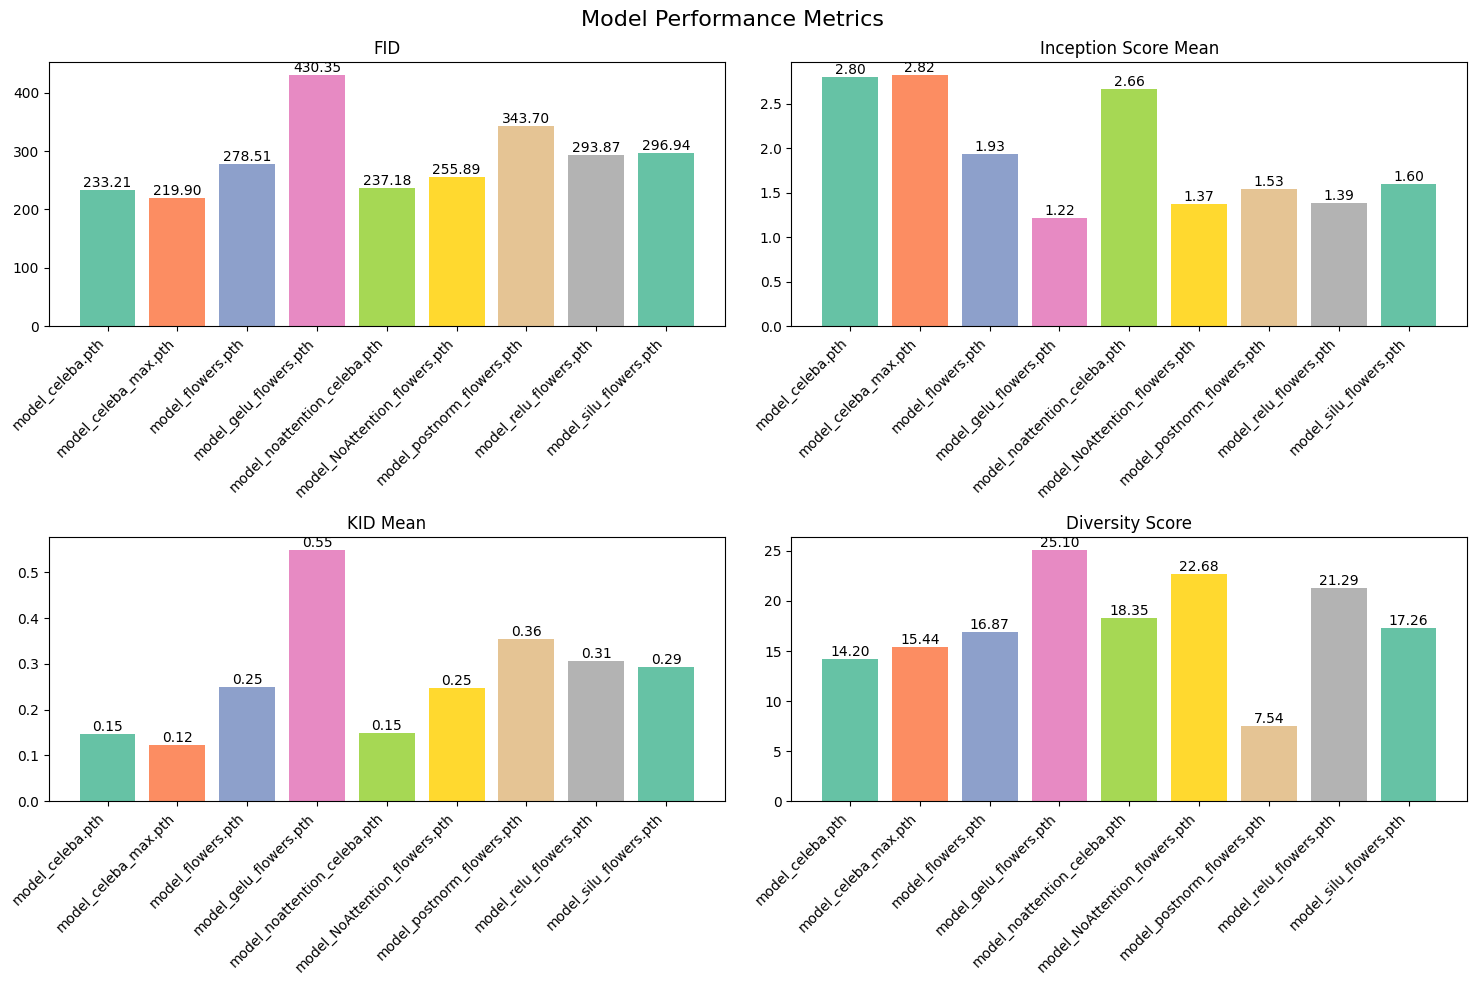

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

color_palette = sns.color_palette("Set2")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Metrics', fontsize=16)

axes = axes.flatten()

metrics = ['FID', 'Inception Score Mean', 'KID Mean', 'Diversity Score']

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    bars = ax.bar(
        metrics_df['Model'], 
        metrics_df[metric], 
        color=color_palette[:len(metrics_df)]
    )
    
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel('')  # Remove x-label as it's redundant
    ax.set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
    
    for j, v in enumerate(metrics_df[metric]):
        ax.text(j, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()